In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

import seaborn as sns

import yaml

import joblib

In [17]:
with open("../../config.yaml", "r") as stream:
    try:
        configs = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [35]:
SEED                       = configs['SEED']
PATH_TO_TRAIN_DS_PROCESSED = str(configs['ROOT_DIR'] + configs['PATH_TO_TRAIN_DS_PROCESSED'])
PATH_TO_EXTRACTED_FEATURES = str(configs['ROOT_DIR'] + configs['PATH_TO_EXTRACTED_FEATURES'])

PATH_TO_MODELS = str(configs['ROOT_DIR'] + configs['PATH_TO_MODELS'])

In [19]:
base           = pd.read_csv(PATH_TO_TRAIN_DS_PROCESSED)

effic_features = pd.read_csv(PATH_TO_EXTRACTED_FEATURES + "EfficientNet-train.csv")
effic_features.drop(effic_features.filter(regex="Unname"),axis=1, inplace=True)

roberta_features  = pd.read_csv(PATH_TO_EXTRACTED_FEATURES + "roberta-base-train.csv")
roberta_features  = roberta_features.iloc[1: , :] #desconsiderando a primeira linha porque só contém zeros! Os zeros foram adicionados para evitar erros na adição de novas linhas no numpy.array em BERT-featureExtractor.ipynb
roberta_features.drop(roberta_features.filter(regex="Unname"),axis=1, inplace=True)

print(base.shape)
base.head()

(5453, 7)


,image_name,text,humour,sarcasm,offensive,motivational,target
0,image_1415.jpeg,if you want to view paradis simpli look around...,not_funny,not_sarcastic,not_offensive,motivational,positive
1,image_6460.png,if i had a brick for everi lie hillari told i ...,hilarious,general,very_offensive,motivational,positive
2,image_2303.png,that thing over there can i eat that,very_funny,general,not_offensive,motivational,very_positive
3,image_2417.png,my dad point to liam and said when did david b...,not_funny,general,very_offensive,motivational,neutral
4,image_11.jpg,probabl the first man to do year challeng chen...,funny,general,very_offensive,motivational,negative


In [20]:
print(roberta_features.shape)
roberta_features.head()

(5453, 768)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
1,-0.622064,0.331342,0.625570,-1.188456,0.890898,-0.297572,-0.087452,0.664493,-0.408972,-1.156423,...,0.415184,0.317160,-0.131766,-0.559810,-0.383801,0.351369,0.110016,0.449329,-0.786426,0.073209
2,-0.604108,0.337911,0.950010,-1.028117,0.515339,-0.150530,-0.114648,0.725604,-0.092860,-0.932656,...,0.326043,0.296483,0.067706,-0.558398,-0.228380,0.049417,0.472585,0.474540,-0.799658,0.027630
3,-0.757757,0.254757,0.857170,-1.022734,0.183830,-0.053854,-0.020377,0.528923,-0.085957,-0.559990,...,0.181596,0.280393,0.112610,-0.526918,-0.338471,0.271118,0.433552,0.559687,-0.774118,-0.074605
4,-0.657207,0.574977,0.775252,-1.314496,0.885670,-0.533778,0.133388,0.776399,-0.804361,-1.487674,...,0.251450,0.408799,-0.164519,-0.577932,-0.502540,0.127542,0.434763,0.481590,-0.771126,-0.040969
5,-0.568037,0.568159,0.926396,-1.076364,0.988210,-0.487285,-0.020380,0.934860,-0.764776,-1.474329,...,0.428683,0.364758,-0.088232,-0.751990,-0.595538,0.215889,0.454045,0.441468,-0.694934,-0.241814


In [21]:
print(effic_features.shape)
effic_features.head()

(5453, 1280)


,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,-0.042384,-0.061363,-0.100872,0.032875,-0.022561,-0.002880,-0.092080,0.154064,0.289251,-0.147277,...,0.172624,0.052139,0.363466,0.393509,-0.039090,-0.089707,-0.078176,-0.053020,0.416281,-0.102968
1,-0.067793,-0.049741,0.318771,-0.042084,0.158128,-0.096783,-0.078802,-0.065242,-0.137934,-0.122118,...,-0.003128,0.215171,0.081113,-0.046309,-0.018203,0.114962,-0.047569,-0.135591,-0.045568,0.074974
2,0.944058,-0.076654,-0.066291,-0.080416,0.814247,-0.065318,-0.112185,2.324079,-0.094965,-0.092683,...,0.721857,-0.149343,0.161383,-0.014381,-0.052333,2.049798,0.108311,0.314507,-0.085552,0.049666
3,0.228229,0.018523,-0.095749,-0.094697,-0.164453,-0.134290,-0.027651,0.295090,-0.090984,-0.110664,...,0.426313,0.282934,-0.037594,1.015053,-0.130066,-0.121831,-0.043130,-0.174937,-0.081547,-0.028557
4,-0.056007,0.172222,0.286570,-0.086260,0.061207,-0.104899,-0.021336,0.992542,-0.032700,-0.037638,...,1.065959,-0.000900,0.529718,-0.035574,-0.118270,0.464599,0.113052,0.444527,0.016761,-0.039775


#### Concatenando os datasets

In [22]:
n_base = pd.DataFrame(np.concatenate((roberta_features, effic_features), axis=1))
n_base['target'] = base.target
print(n_base.shape)
n_base.head()

(5453, 2049)


,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,target
0,-0.622064,0.331342,0.625570,-1.188456,0.890898,-0.297572,-0.087452,0.664493,-0.408972,-1.156423,...,0.052139,0.363466,0.393509,-0.039090,-0.089707,-0.078176,-0.053020,0.416281,-0.102968,positive
1,-0.604108,0.337911,0.950010,-1.028117,0.515339,-0.150530,-0.114648,0.725604,-0.092860,-0.932656,...,0.215171,0.081113,-0.046309,-0.018203,0.114962,-0.047569,-0.135591,-0.045568,0.074974,positive
2,-0.757757,0.254757,0.857170,-1.022734,0.183830,-0.053854,-0.020377,0.528923,-0.085957,-0.559990,...,-0.149343,0.161383,-0.014381,-0.052333,2.049798,0.108311,0.314507,-0.085552,0.049666,very_positive
3,-0.657207,0.574977,0.775252,-1.314496,0.885670,-0.533778,0.133388,0.776399,-0.804361,-1.487674,...,0.282934,-0.037594,1.015053,-0.130066,-0.121831,-0.043130,-0.174937,-0.081547,-0.028557,neutral
4,-0.568037,0.568159,0.926396,-1.076364,0.988210,-0.487285,-0.020380,0.934860,-0.764776,-1.474329,...,-0.000900,0.529718,-0.035574,-0.118270,0.464599,0.113052,0.444527,0.016761,-0.039775,negative


#### Considerando somente as labels 'negative', 'neutral' e 'positive'.

In [23]:
n_base.target.replace("very_positive", 
           "positive", 
           inplace=True)
n_base.target.replace("very_negative", 
           "negative", 
           inplace=True)    
NUM_LABELS = len(n_base.target.unique())
n_base.target = n_base.target.astype('category').cat.codes
n_base.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,target
0,-0.622064,0.331342,0.625570,-1.188456,0.890898,-0.297572,-0.087452,0.664493,-0.408972,-1.156423,...,0.052139,0.363466,0.393509,-0.039090,-0.089707,-0.078176,-0.053020,0.416281,-0.102968,2
1,-0.604108,0.337911,0.950010,-1.028117,0.515339,-0.150530,-0.114648,0.725604,-0.092860,-0.932656,...,0.215171,0.081113,-0.046309,-0.018203,0.114962,-0.047569,-0.135591,-0.045568,0.074974,2
2,-0.757757,0.254757,0.857170,-1.022734,0.183830,-0.053854,-0.020377,0.528923,-0.085957,-0.559990,...,-0.149343,0.161383,-0.014381,-0.052333,2.049798,0.108311,0.314507,-0.085552,0.049666,2
3,-0.657207,0.574977,0.775252,-1.314496,0.885670,-0.533778,0.133388,0.776399,-0.804361,-1.487674,...,0.282934,-0.037594,1.015053,-0.130066,-0.121831,-0.043130,-0.174937,-0.081547,-0.028557,1
4,-0.568037,0.568159,0.926396,-1.076364,0.988210,-0.487285,-0.020380,0.934860,-0.764776,-1.474329,...,-0.000900,0.529718,-0.035574,-0.118270,0.464599,0.113052,0.444527,0.016761,-0.039775,0


#### Separação do treino e validação

In [24]:
train, val = train_test_split(n_base, test_size=0.2, random_state = SEED)
print(train.shape, val.shape)
train.head()

(4362, 2049) (1091, 2049)


,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,target
4223,-0.618610,0.463183,0.744717,-1.020731,0.811868,-0.058083,-0.183214,0.905942,-0.576029,-1.222059,...,0.028469,-0.040667,0.001379,-0.114967,0.336742,0.771530,0.698421,-0.092796,0.181799,2
1202,-0.488849,0.114717,0.655202,-0.744915,0.074412,-0.013242,0.052030,0.365005,0.099475,-0.242165,...,0.653883,0.261644,-0.046154,0.082290,2.504019,-0.098325,0.797305,-0.070982,0.407613,0
3262,-0.745462,0.269164,0.793629,-1.031668,0.535627,-0.082444,0.145839,0.741332,-0.243830,-1.010863,...,0.302966,-0.075838,0.623002,-0.057209,-0.034645,0.518699,-0.007314,0.211534,0.712135,2
4683,-0.760727,0.404997,0.687271,-1.241401,0.801400,-0.131036,-0.002606,0.973352,-0.548477,-1.094265,...,0.795708,-0.009668,3.446804,-0.107725,1.102325,-0.099896,1.223172,0.688118,0.733896,2
2600,-0.737530,0.218970,0.868654,-0.936520,0.252549,-0.098225,-0.081343,0.593797,0.059835,-0.550901,...,-0.019553,0.211147,0.125435,0.096978,-0.080829,-0.077035,0.394715,0.280398,-0.036882,2


In [25]:
X_train, y_train = train.iloc[:,:-1], train.target
X_val, y_val     = val.iloc[:,:-1], val.target

#### Balanceadomento das classes

In [26]:
weights = class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(train.target) ,y = train.target).ravel()
class_weights = dict((i,v) for i, v in enumerate(weights))
class_weights

{0: 3.5901234567901232, 1: 1.0699043414275202, 2: 0.5596612779060816}

# Random Forest

In [27]:
rfc = RandomForestClassifier(random_state = SEED, class_weight = class_weights)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [28]:
grid = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.464 total time=   8.2s
[CV 2/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.405 total time=   8.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.444 total time=   8.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.451 total time=   7.9s
[CV 5/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.460 total time=   7.9s
[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.472 total time=  19.8s
[CV 2/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.411 total time=  21.2s
[CV 3/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.435 total time=  20.1s
[CV 4/5] END criterion=gini, max_depth=4, max_feat

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 3.5901234567901232,
                                                            1: 1.0699043414275202,
                                                            2: 0.5596612779060816},
                                              random_state=2),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             verbose=3)

In [29]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [30]:
y_pred = grid.predict(X_train)
print("Treino - balanced_accuracy : ", balanced_accuracy_score(y_train,  y_pred))
print("Treino - F1 : ", f1_score(y_train, y_pred, average='macro'))

Treino - balanced_accuracy :  0.999871696176546
Treino - F1 :  0.9995248205319305


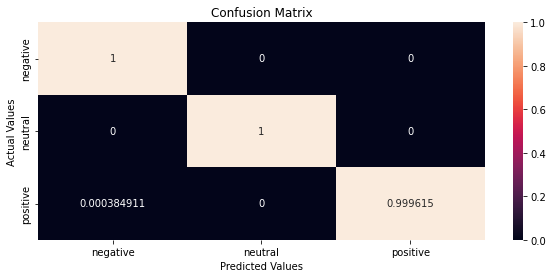

In [31]:
labels = ['negative', 'neutral', 'positive']
cm = confusion_matrix(y_train, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,
                     index = labels, 
                     columns = labels
                     )

plt.figure(figsize=(10,4))
sns.heatmap(cm_df, annot=True ,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [32]:
y_pred = grid.predict(X_val)
print("Validacao - balanced_accuracy : ", balanced_accuracy_score(y_val,  y_pred))
print("Validacao - F1 : ", f1_score(y_val, y_pred, average='macro'))

Validacao - balanced_accuracy :  0.33036934578208105
Validacao - F1 :  0.287013251783894


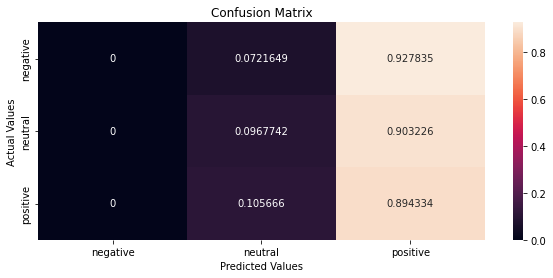

In [33]:
labels = ['negative', 'neutral', 'positive']
cm = confusion_matrix(y_val, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,
                     index = labels, 
                     columns = labels
                     )

plt.figure(figsize=(10,4))
sns.heatmap(cm_df, annot=True ,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Salvando o modelo

In [36]:
joblib.dump(grid, PATH_TO_MODELS + "RF/RandomForest-concatFeatures(roBERTa-Effic).joblib")
#rfc = joblib.load(PATH_TO_MODELS + "RF/RandomForest-concatFeatures(BERT-Effic).joblib")

['B:\\utils\\Documentos\\MDC\\projeto_final\\meme-sentiment-analysis/meme-sentiment-analysis/models/saved/models/RF/RandomForest-concatFeatures(roBERTa-Effic).joblib']